In [7]:
from modules.models import KdVBurgersPinn, create_dense_model, create_dense_model_Normalized, FourierFeatures
from modules.data import simulate_kdvburgers
from modules.plots import plot_KdV_model, plot_training_loss
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [8]:
! git add KdVB.ipynb
! git commit -m "cleaned up KdVB.ipynb"


Refresh index: 100% (83/83), done.
On branch main
Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	deleted:    BPtravelKawahara.ipynb
	deleted:    BloodFlow.ipynb
	modified:   KPSingleSoliton.ipynb
	modified:   KPXConfig.ipynb
	modified:   KPYConfig.ipynb
	modified:   KdVB.ipynb
	modified:   KdVBDispersiveTail.ipynb
	modified:   KdVThreeSoliton.ipynb
	deleted:    advection.ipynb
	deleted:    burgers.ipynb
	deleted:    heat.ipynb
	deleted:    poisson.ipynb
	deleted:    reaction_diffusion.ipynb
	deleted:    schrodinger.ipynb
	deleted:    transport.ipynb
	deleted:    wave.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	../HyperparameterTuning.ipynb
	FinalPictures/
	GIF/
	GIFs/
	KPPinnTime15.pickle
	KdVBAlfonsoPaper.ipynb
	KdVDoubleSoliton64-128-128-128-64.pickle
	KdVDoubleSolitonAdded64-128-128-128-64.pickle
	KdVSingleSolitonTime1

In [ ]:
!git config --global user.name "Nadia Aiaseh"
!git config --global user.email "naiaseh@uwo.ca"


In [4]:
from google.colab import drive # for colab only
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.chdir("/content/drive/MyDrive/Trunk/PinnNew") # for colab only, may need to be changed to the exact path on the local set up.
print(os.getcwdb())

b'/content/drive/MyDrive/Trunk/PinnNew'


# Initial condition construction

### IC from [Alfonso, M. R., Cymberknop, L. J., Legnani, W., Pessana, F., & Armentano, R. L. (2014, August). Conceptual model of arterial tree based on solitons by compartments. In 2014 36th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (pp. 3224-3227). IEEE.](https://ieeexplore.ieee.org/abstract/document/6944309?casa_token=SM-BSwBICzMAAAAA:4lTjllpOEUUuGhkXP7aF610ToEJZhOWO38WJJ7Mm6Gb8sEiC88OgGE_UQauuglD9gc-RFwIBzl4)

In this paper physiological parameters are used, roles of time and space are reversed.

In [6]:
E = 4 # measure of artery elasticity x10^6 dyn/cm^2
h = 0.076 # wall thickiness
R = 0.52 # radius


rho = 1.05 # blood density
rhow= 1.06 # wall density
c0 = tf.sqrt(E*h/(2*rho*R)) # Moens-Korteweg velocity
d0 = 1./c0 # u_x term coefficient
d1 = -(1+1./2)*1/(rho*c0**3) # nonlinear term coeff
d2 = -rhow*h*R/(2*rho*c0**3) # dispersive term coeff

phi = 80. # added background pressure
alpha = 0. # dissipation term coeff
beta = d2
gamma = d1




def phi_function(tx):
    S1 = -0.9 # S1, S2, a1, a2 chosen such that our profile qualitatively matches that of the cited paper
    S2 = -0.9
    a1 = 11.
    a2 = 16.
    f1 = tf.exp(-a1 *(tx[:, 1:2]- (d0 + a1**2 * d2)*tx[:,0:1]+S1))
    f2 = tf.exp(-a2 *(tx[:, 1:2]- (d0 + a2**2 * d2)*tx[:,0:1]+S2))
    numer = a1**2 *f1 + a2**2 *f2 + 2* ((a1-a2)/(a1+a2))**2 * (a1**2 * f1*f2**2 + a2**2 * f2*f1**2)
    denom = (1+ f1 + f2 + ((a1-a2)/(a1+a2))**2 *f1*f2)**2
    u = 12*d2/d1 * numer/denom + phi
    u = tf.where(tf.math.is_nan(u), 0., u)
    return u

def boundary_function(tx):
    return phi*tf.ones_like(tx[:, 1:])

x_start =  -1. # start time
length = 2. # finish time
t0 = 0. # start length
time = 4. # finish length

NameError: name 'tf' is not defined

### Small-amplitude KdV-B soliton from [Xenos, M. A., & Felias, A. C. (2021). Nonlinear dynamics of the KdV-B equation and its biomedical applications. Nonlinear Analysis, Differential Equations, and Applications, 765-793.](https://link.springer.com/chapter/10.1007/978-3-030-72563-1_26)
equation 26

In [ ]:




alpha = 0.01 # dissipation term coeff
beta = 0.5 # dispersive term coeff (d2 in the paper)
gamma = 1. # nonlinear term coeff (d1 in the paper)
c0 = 1.
k = 0.1 # chose a small wavenumber
phi = 2*k/gamma * 2 * (alpha + 2*beta*k)
c = c0
ampl = 2*k/gamma * (alpha + 6*beta*k) # needed for normalization
phi = phi/ampl

def phi_function(tx):
    offset =  0.
    ksi = tx[:, 1:2]-c*tx[:,0:1]+offset
    u = 2*k/gamma *(2 * (alpha + 2*beta*k) + (alpha + 6*beta*k) * 1/tf.cosh(k*ksi)**2 )

    return u/ampl


def boundary_function(tx):
    return phi*tf.ones_like(tx[:, 1:])

# domain enlarged to fit the soliton and respect BCs.
x_start =  -300.
length = 300.
t0 = 0.
time = 6000.

### one-soliton initial condition rescaled according to PDE coefficients




In [3]:


def phi_function(tx):
    offset =  0.
    ksi = tx[:, 1:2]-c0*tx[:,0:1]+offset
    ampl = 3*c0/gamma
    multiplier = c0/(beta*4)
    u = ampl / tf.cosh(np.sqrt(multiplier)*ksi)**2
    u = tf.where(tf.math.is_nan(u), 0., u)
    return u

def boundary_function(tx):
    return phi*tf.ones_like(tx[:, 1:])


x_start =  -20.
length = 20.
t0 = 0.
time = 10.


### Three-soliton linear combination

In [1]:
phi = 0.
alpha = 0.1
beta = 1.
gamma = 6.

c1 = 4.
c2 = 0.5
a1 = tf.sqrt(c1/(4*beta))
a2 = tf.sqrt(c2/(4*beta))
a3 = 0.

def boundary_function(tx):
    return phi*tf.ones_like(tx[:, 1:])

def phi_function(tx, dtype = tf.float32):
  A12 = ((a1-a2)/(a1+a2))**2
  A13 = ((a1-a3)/(a1+a3))**2
  A23 = ((a2-a3)/(a2+a3))**2
  A = A12*A13*A23

  theta1 = a1* tx[:,1:2] - 4.*a1**3 * tx[:,0:1] + a1*12.
  theta2 = a2* tx[:,1:2] - 4.*a2**3 * tx[:,0:1] +a2*-8.

  theta3 = a3* tx[:,1:2]- 4.*a3**3 * tx[:,0:1]

    # delta1 = 0.
    # delta2 = 0.
    # delta3 = 0.
  delta1 = -1/4 * tf.math.log(A12*A13)
  delta2 = -1/4 * tf.math.log(A12*A23)
  delta3 = -1/4 * tf.math.log(A23*A13)


  theta1 = theta1 + delta1
  theta2 = theta2 + delta2
  theta3 = theta3 + delta3


  F = 1 + tf.math.exp(2*theta1) + tf.math.exp(2*theta2) + tf.math.exp(2*theta3) + A12*tf.math.exp(2*(theta1 + theta2)) + A13*tf.math.exp(2*(theta1 + theta3)) + \
  A23*tf.math.exp(2*(theta2 + theta3)) + A*tf.math.exp(2*(theta1 + theta2 + theta3))

  Fprimeprime = 4*a1**2 * tf.math.exp(2*theta1) + 4*a2**2 * tf.math.exp(2*theta2) + 4*a3**2 * tf.math.exp(2*theta3) + \
  (2*a1 + 2*a2)**2 * A12*tf.math.exp(2*(theta1 + theta2)) + (2*a1 + 2*a3)**2 * A13*tf.math.exp(2*(theta1 + theta3)) + \
  (2*a2 + 2*a3)**2 * A23*tf.math.exp(2*(theta2 + theta3)) + (2*a1 + 2*a2 + 2*a3)**2 * A*tf.math.exp(2*(theta1 + theta2 + theta3))

  Fprime = 2*a1* tf.math.exp(2*theta1) + 2*a2* tf.math.exp(2*theta2) + 2*a3* tf.math.exp(2*theta3) +\
  (2*a1+2*a2) * A12*tf.math.exp(2*(theta1 + theta2)) + (2*a1 + 2*a3) * A13*tf.math.exp(2*(theta1 + theta3)) + \
  (2*a2 + 2*a3) * A23*tf.math.exp(2*(theta2 + theta3)) + 2*(a1+a2+a3) * A*tf.math.exp(2*(theta1 + theta2 + theta3))

  u = 2*Fprimeprime/F - 2* (Fprime/F)**2

  u = tf.where(tf.math.is_nan(u), 0., u)
  u = tf.where(tf.math.is_inf(u), 0., u)
  return tf.cast(u, dtype)

def phi_function_solitonsAdded(tx,offset1 = 12.,offset2 = -8):


    ksi = tx[:, 1:2]-c1*tx[:,0:1] + offset1+0.5
    ksi2 = tx[:, 1:2]-c2*tx[:,0:1] + offset2-1.2

    u = c1*3 / (gamma*tf.cosh(a1*(ksi))**2)
    u2 = c2*3 / (gamma*tf.cosh(a2*(ksi2))**2)

    u = tf.where(tf.math.is_nan(u), 0., u)
    u2 = tf.where(tf.math.is_nan(u2), 0., u2)

    total = u + u2
    return total

x_start =  -50. #-10
length = 50.#10
t0 = 0.
time = 10.

NameError: name 'tf' is not defined

# Plotting the IC

In [2]:

N =  128
TIME = 0.
xt = np.linspace(x_start,length,N).T

tt = np.zeros((N,1))
xt = xt.reshape(-1,1)

tt = tt.reshape(-1,1)
txy2 = np.stack([np.full(tt.shape, TIME),  xt ], axis=1)
txy3 = np.stack([np.full(tt.shape, time),  xt ], axis=1)
u2 = phi_function(txy2)
u2 = tf.reshape(u2, [xt.shape[0],xt.shape[1]])

u3 = phi_function(txy3)
u3 = tf.reshape(u3, [xt.shape[0],xt.shape[1]])
plt.plot(xt, u2)
plt.plot(xt, u3)

# plt.xlim([0,20])
plt.xlabel('x')
plt.ylabel('u(x,y,t)')
# plt.ylim([80,140])

NameError: name 'np' is not defined

# Data Generation
tx_eqn: PDE domain <br>
y_eqn: r.h.s of the PDE (zeros in our case) <br>
tx_init: initial condition domain (i.e. initial time and space domain) <br>
y_init: wave profile at the initial time or IC <br>
tx_boundary: boundary condition domain (i.e. spatial bounds and time domain) <br>
y_boundary: wave profile evaluated at the bounds or BC <br>

In [ ]:
(tx_eqn, y_eqn), (tx_init, y_init), (tx_boundary, y_boundary) = simulate_kdvburgers(30_000, phi_function, boundary_function, x_start, length, t0, time, n_init = None, n_bnd = None, random_seed = 42, dtype=tf.float32)




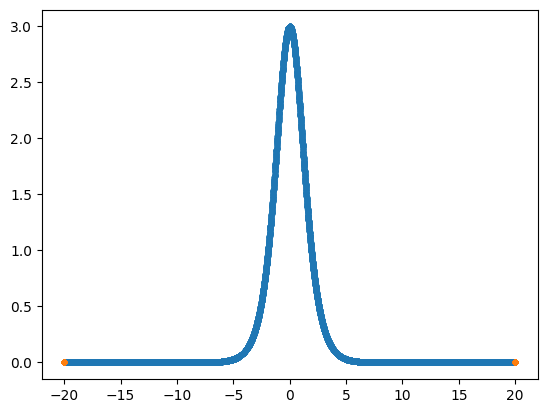

In [ ]:

plt.plot( tx_init[:,1:], phi_function(tx_init),'.')
plt.plot( tx_boundary[:,1:], y_boundary,'.')


In [ ]:
 ### create data = [inputs, outputs] for the PINN ###
inputs = [tx_eqn, tx_init, tx_boundary]
outputs = [phi_function(tx_eqn), y_eqn, y_init, y_boundary]


# Creating and Training the PINN

In [ ]:
### create and compile the PINN ###

backbone = create_dense_model([32, 32, 32], activation='tanh', initializer='glorot_normal',\
    n_inputs=2, n_outputs=1)
pinn = KdVBurgersPinn(backbone, alpha=alpha, beta=beta, gamma=gamma,c=0., loss_residual_weight = 1.)
a0 = 1e-3
decay_step = 1000
rate = 0.95
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(a0, decay_steps= decay_step, decay_rate= rate)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler, clipnorm=1.)
pinn.compile(optimizer=optimizer)

In [ ]:
### train the PINN ###
history = pinn.fit_custom(inputs, outputs, epochs = 50_000, print_every = 500) # custom method
# history = pinn.fit(inputs, outputs, batch_size = 30000, epochs = 4000) # built-in from tf

Epoch 0, Loss Residual: 2.6425402164, Loss Initial: 0.5143480897, Loss Boundary: 0.0372353382, MAE: 0.4515737593
Epoch 500, Loss Residual: 0.0350813232, Loss Initial: 0.1375838965, Loss Boundary: 0.0004721956, MAE: 0.2663941979
Epoch 1000, Loss Residual: 0.0106109651, Loss Initial: 0.0086486796, Loss Boundary: 0.0002561912, MAE: 0.2729547918
Epoch 1500, Loss Residual: 0.0039746631, Loss Initial: 0.0021017021, Loss Boundary: 0.0001514494, MAE: 0.2717861831
Epoch 2000, Loss Residual: 0.0024184426, Loss Initial: 0.0012842327, Loss Boundary: 0.0001176854, MAE: 0.2712648809
Epoch 2500, Loss Residual: 0.0017400600, Loss Initial: 0.0009308898, Loss Boundary: 0.0000902744, MAE: 0.2706861198
Epoch 3000, Loss Residual: 0.0011887172, Loss Initial: 0.0007060860, Loss Boundary: 0.0000702242, MAE: 0.2702686191
Epoch 3500, Loss Residual: 0.0008381957, Loss Initial: 0.0005618997, Loss Boundary: 0.0000559315, MAE: 0.2697266638
Epoch 4000, Loss Residual: 0.0007051628, Loss Initial: 0.0004701288, Loss Bo

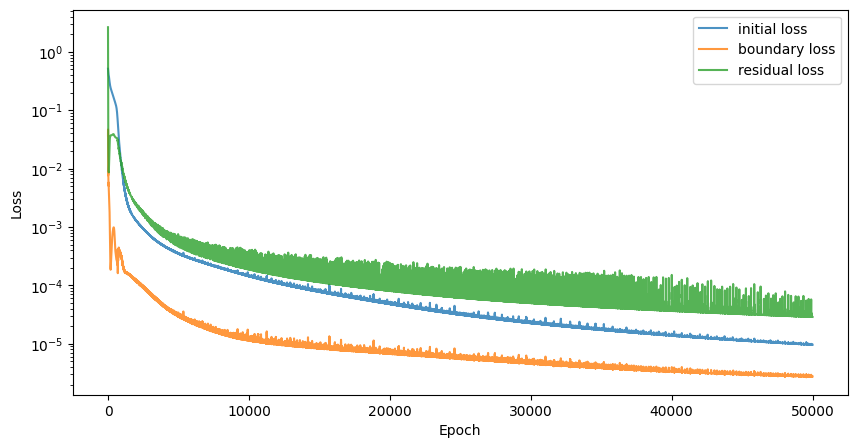

In [ ]:
 history2 = {k: history[k] for k in ('loss_total', 'loss_residual', 'loss_initial', 'loss_boundary')}

plot_training_loss(history2, y_scale='log')



In [ ]:
plt.figure(figsize=(10, 5), dpi = 100)
plt.yscale('log')
plt.plot(history['mean_absolute_error'], label='mean absolute error', alpha = 0.8)
plt.xlabel('Epoch')
plt.ylabel('MAE')

NameError: name 'plt' is not defined

# Plotting the Solution

1/1 [==============================] - 0s 15ms/step


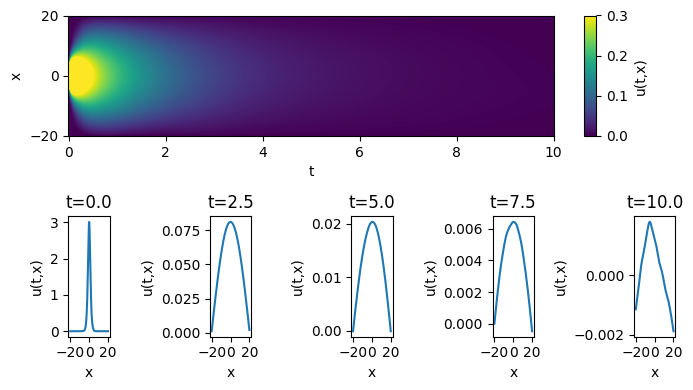

In [ ]:
plot_KdV_model(pinn.backbone, x_start,length, time, -0, 0.3, t0 = t0, save_path = None, show=True)

1000/1000 [==============================] - 1s 1ms/step


Text(0, 0.5, '$t$')

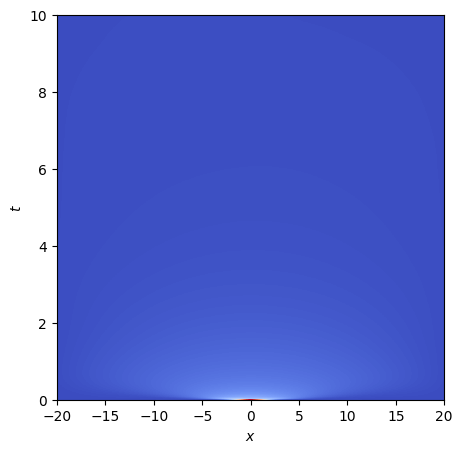

In [ ]:
    from matplotlib.gridspec import GridSpec

    num_test_samples = 1000
    t_flat = np.linspace(t0, time, num_test_samples)
    x_flat = np.linspace(x_start, length, num_test_samples)
    t, x = np.meshgrid(t_flat, x_flat)
    tx = np.stack([t.flatten(), x.flatten()], axis=-1) #
    u = pinn.backbone.predict(tx, batch_size=num_test_samples)
    u = u.reshape(t.shape)

    fig = plt.figure(figsize=(5,5))
    gs = GridSpec(1, 1)
    plt.subplot(gs[:, :])
    plt.pcolormesh(x, t, u, cmap = 'coolwarm', shading='auto')
    plt.xlabel('$x$')
    plt.ylabel('$t$')


In [ ]:
def plot_snapshots(timeList,num_test_samples = 1000, phi_function = phi_function, pinn = pinn):
    x_flat = np.linspace(x_start, length, num_test_samples)
    t_flat = np.linspace(t0, time, num_test_samples)
    x_flat = tf.convert_to_tensor(x_flat)
    t_flat = tf.convert_to_tensor(t_flat)

    dt=time/(num_test_samples-1)
    t_cross_sections = timeList
    for i, t_cs in enumerate(t_cross_sections):
        tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
        print(tx.shape)
        u = pinn.backbone.predict(tx, batch_size=num_test_samples)
        plt.plot(x_flat, u, label = 'prediction at time {}'.format(t_cs))

        plt.xlabel('x')
        plt.ylabel('u(t,x)')

    return

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 1000
xspace = np.linspace(x_start, length, N + 1)
tspace = np.linspace(t0, time, N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)

upred = pinn.backbone.predict(Xgrid)

# Reshape upred
U = upred.reshape(N+1,N+1)

# Surface plot of solution u(t,x)

31313/31313 [==============================] - 37s 1ms/step


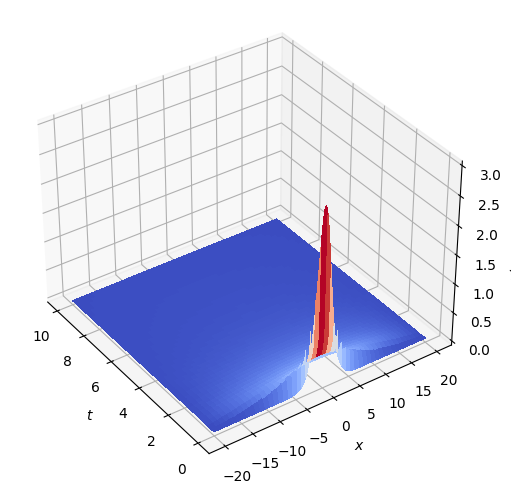

In [ ]:
from matplotlib import cm
from matplotlib.colors import LightSource
from matplotlib.ticker import LinearLocator
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')


ax.plot_surface(T, X, U, cmap='coolwarm', antialiased = False, linewidth=0);
ax.view_init(35,-35,0)
# ax.view_init(90,-90,0)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u(x,t)$')
ax.invert_xaxis()
# ax.set_title('Solution of KdV equation');


### To set or write to pickle files

In [ ]:
# to set

# with open('PickleFiles/KdVePINNs/comp5.pickle', 'rb') as f:
#     my_weights = pickle.load(f)
# pinn.backbone.set_weights(my_weights)
# with open('PickleFiles/KdVB/Alpha0/HistoryKdVBalpha0-5Time10-3x32.pickle', 'rb') as f:
#   history = pickle.load(f)

# to write
with open('PickleFiles/KdVB/Alpha100/HistoryKdVBalpha100Time10-3x32.pickle', 'wb') as fp:
    pickle.dump(history, fp)

current_weights = pinn.backbone.get_weights()
with open('PickleFiles/KdVB/Alpha100/KdVBalpha100Time10-3x32.pickle', 'wb') as f:
    pickle.dump(current_weights, f)

FileNotFoundError: [Errno 2] No such file or directory: 'PickleFiles/KdVB/Alpha100/HistoryKdVBalpha100Time10-3x32.pickle'